###### The goal of this notebook is to apply three main classification approaches used in data mining: Naïve Bayes, Decision Trees, and K-Nearest Neighbors. 

The dataset used for this task is the Spotify Dataset 

In [1]:
import numpy as np
import pandas as pd
import scipy.stats 
import matplotlib.pyplot as plt

#### 1.1.Describe the data 

In [2]:
#load data
music_tb=pd.read_csv("Spotify_Combined.csv").drop("index",axis=1)

#### The Distribution of the Class Attribute

In [3]:
music_tb["mood(s)"].value_counts() #series

dinner             467
sleep              362
workout            310
party              225
party, workout      52
dinner, party        3
dinner, workout      1
Name: mood(s), dtype: int64

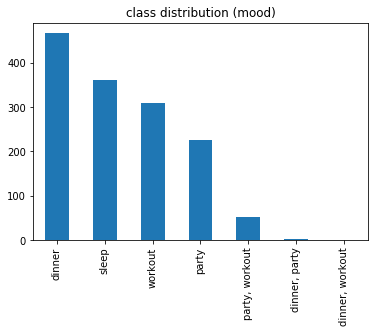

In [4]:
music_tb["mood(s)"].value_counts().plot.bar()
plt.title("class distribution (mood)")
plt.show()

#### The bar plot shows the distribution of classes, there are 3 classes (party,workout / dinner,party/dinner, workout) are minority classes, we might want to reassign these 3 classes before classification to make sure the classifier would learn the pattern accurately.

#### The approach I take to reassign the label for instances with minority classes is through clustering. I first assume the 4 dominant classes are 4 clusters, then I derive their centroid by measuring the mean value for their instances of each class. 

#### For the instances with minority classes, based on their label names I measure their distance from the centroids of two most relevant classes then assign the new class labels that have centroids closest to those instances.


In [5]:
#organize the dataframe
party_workout=music_tb.loc[music_tb["mood(s)"]=="party, workout"].drop("id",axis=1).drop("name",axis=1).drop("uri",axis=1).drop("artist",axis=1).drop("mood(s)",axis=1)
dinner_party=music_tb.loc[music_tb["mood(s)"]=="dinner, party"].drop("id",axis=1).drop("name",axis=1).drop("uri",axis=1).drop("artist",axis=1).drop("mood(s)",axis=1)
dinner_workout=music_tb.loc[music_tb["mood(s)"]=="dinner, workout"].drop("id",axis=1).drop("name",axis=1).drop("uri",axis=1).drop("artist",axis=1).drop("mood(s)",axis=1)
tb=music_tb.drop(party_workout.index,axis=0).drop(dinner_party.index,axis=0).drop(dinner_workout.index,axis=0)
tb=tb.drop("id",axis=1).drop("name",axis=1).drop("uri",axis=1).drop("artist",axis=1)
tb_dinner=tb.loc[tb["mood(s)"]=="dinner"].drop("mood(s)",axis=1)
tb_workout=tb.loc[tb["mood(s)"]=="workout"].drop("mood(s)",axis=1)
tb_party=tb.loc[tb["mood(s)"]=="party"].drop("mood(s)",axis=1)

In [6]:
#write a function to calculate the center and measure the distance between the center and the instance
def rebin(two_class_instance,plain_class_tb1,plain_class_tb2,name):
    center1=plain_class_tb1.mean()
    center2=plain_class_tb2.mean()
    decision={}
    final=[]
    for i in two_class_instance.index:
        a=np.sqrt(np.dot(two_class_instance.loc[i]-center1,(two_class_instance.loc[i]-center1).T))
        decision[name[0]]=a
        b=np.sqrt(np.dot(two_class_instance.loc[i]-center2,(two_class_instance.loc[i]-center2).T))
        decision[name[1]]=b
        if decision[name[0]]== min(decision[name[0]],decision[name[1]]):
            final.append(name[0])
        else:
            final.append(name[1])
    tb=pd.concat([two_class_instance.reset_index(),pd.DataFrame(final,columns=["mood(s)"])],axis=1)
   
    return(tb)

In [7]:
rebin_party_workout=rebin(party_workout,tb_party,tb_workout,name=["party","workout"])
rebin_dinner_party=rebin(dinner_party,tb_dinner,tb_party,name=["dinner","party"])
rebin_dinner_workout=rebin(dinner_workout,tb_dinner,tb_workout,name=["dinner","workout"])

In [8]:
rebin_tb=pd.concat([rebin_party_workout.drop("index",axis=1),rebin_dinner_party.drop("index",axis=1)],axis=0)
rebin=pd.concat([rebin_tb,rebin_dinner_workout.drop("index",axis=1)],axis=0)
rebin=pd.concat([rebin,tb],axis=0).reset_index().drop("index",axis=1)

#### The Distribution for the Relatively Balanced Class after Reassign Label for the Minority CLass

In [9]:
rebin["mood(s)"].value_counts()

dinner     467
sleep      362
workout    324
party      267
Name: mood(s), dtype: int64

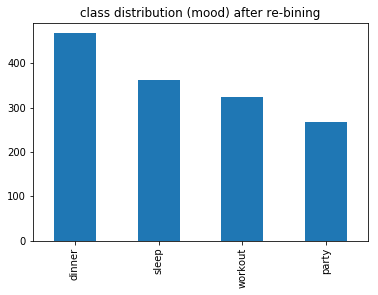

In [10]:
rebin["mood(s)"].value_counts().plot.bar()
plt.title("class distribution (mood) after re-bining")
plt.show()

#### The Feature Distribution for Numerical Attributes

In [11]:
rebin.describe().T

,count,mean,std,min,25%,50%,75%,max
acousticness,1420.0,0.399612,0.381397,0.000023,0.031525,0.265000,0.815000,0.996
danceability,1420.0,0.556092,0.189472,0.058500,0.447750,0.588000,0.691000,0.967
duration_ms,1420.0,283411.478873,337189.066106,54333.000000,196137.250000,226800.000000,274516.750000,4500037.000
energy,1420.0,0.554682,0.294056,0.001540,0.317750,0.596500,0.801000,1.000
instrumentalness,1420.0,0.280521,0.392521,0.000000,0.000001,0.002075,0.795500,0.996
key,1420.0,5.138732,3.565522,0.000000,2.000000,5.000000,8.000000,11.000
liveness,1420.0,0.191559,0.165740,0.022700,0.096675,0.121000,0.231250,0.979
loudness,1420.0,-10.738530,7.986422,-41.808000,-14.406000,-7.811000,-5.034500,-0.750
mode,1420.0,0.588028,0.492363,0.000000,0.000000,1.000000,1.000000,1.000
speechiness,1420.0,0.082647,0.082892,0.022900,0.037000,0.048750,0.081425,0.520


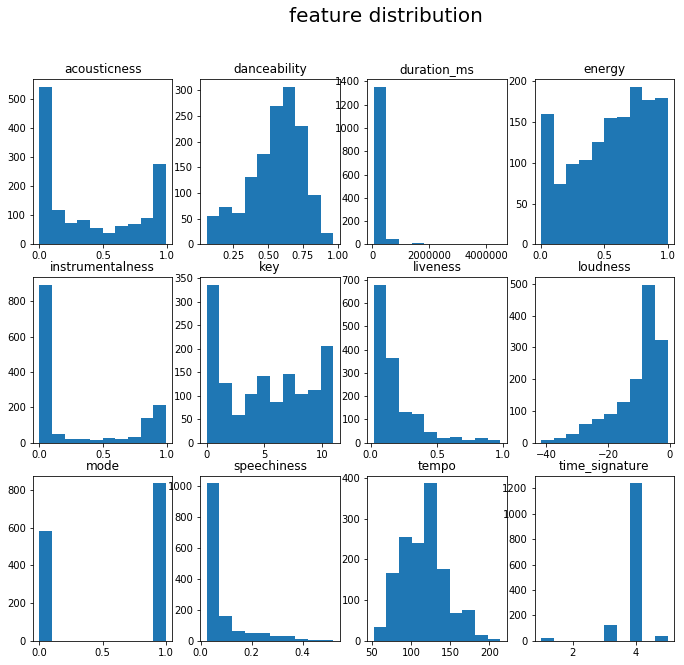

In [12]:
#feature distribution
fig,axis=plt.subplots(nrows=3,ncols=4,figsize=(10,10))
for r in range(3):
    for c in range(4):
        if r<1:
            axis[r,c].hist(rebin[rebin.columns.values[c]])
            axis[r,c].set_title("{}".format(rebin.columns.values[c]))
            continue
                                
        elif 1<=r<2:
            n=c+4
            axis[r,c].hist(rebin[rebin.columns.values[n]])
            axis[r,c].set_title("{}".format(rebin.columns.values[n]))
            continue
                                
        elif 2<=r<3:
            n=c+8
            axis[r,c].hist(rebin[rebin.columns.values[n]])
            axis[r,c].set_title("{}".format(rebin.columns.values[n]))
        
fig.suptitle("feature distribution",fontsize=20)   
plt.subplots_adjust(left=0.01,bottom=0.1)
plt.show()

#### We can learn that only two features the danceability and the tempo are close to normal distributions, therefore, we can normalize the data to solve this issue also to make sure all the features be in the same scale. 



In [13]:
#detect outliers

xtb=rebin.drop("mood(s)",axis=1)
y=rebin[["mood(s)"]]
three_iqr=3*(scipy.stats.iqr(xtb,axis=0))
feature_min=xtb.describe().loc["min"]
feature_max=xtb.describe().loc["max"]
lower_bound=feature_min-three_iqr
upper_bound=feature_max+three_iqr

for i in range(1420):
    if (xtb.iloc[i]<lower_bound).any()==True:
        print(i)
    if (xtb.iloc[i]>upper_bound).any()==True:
        print(i)

#### 1.2.	Plot the data using different colors/signs to represent points belonging to different classes. 

In [14]:
color=rebin["mood(s)"].replace("dinner",1).replace("workout",2).replace("sleep",3).replace("party",4)

In [15]:
col=np.array(['acousticness', 'danceability',
       'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness',
       'loudness', 'speechiness', 'tempo', 'time_signature',
       'valence'])

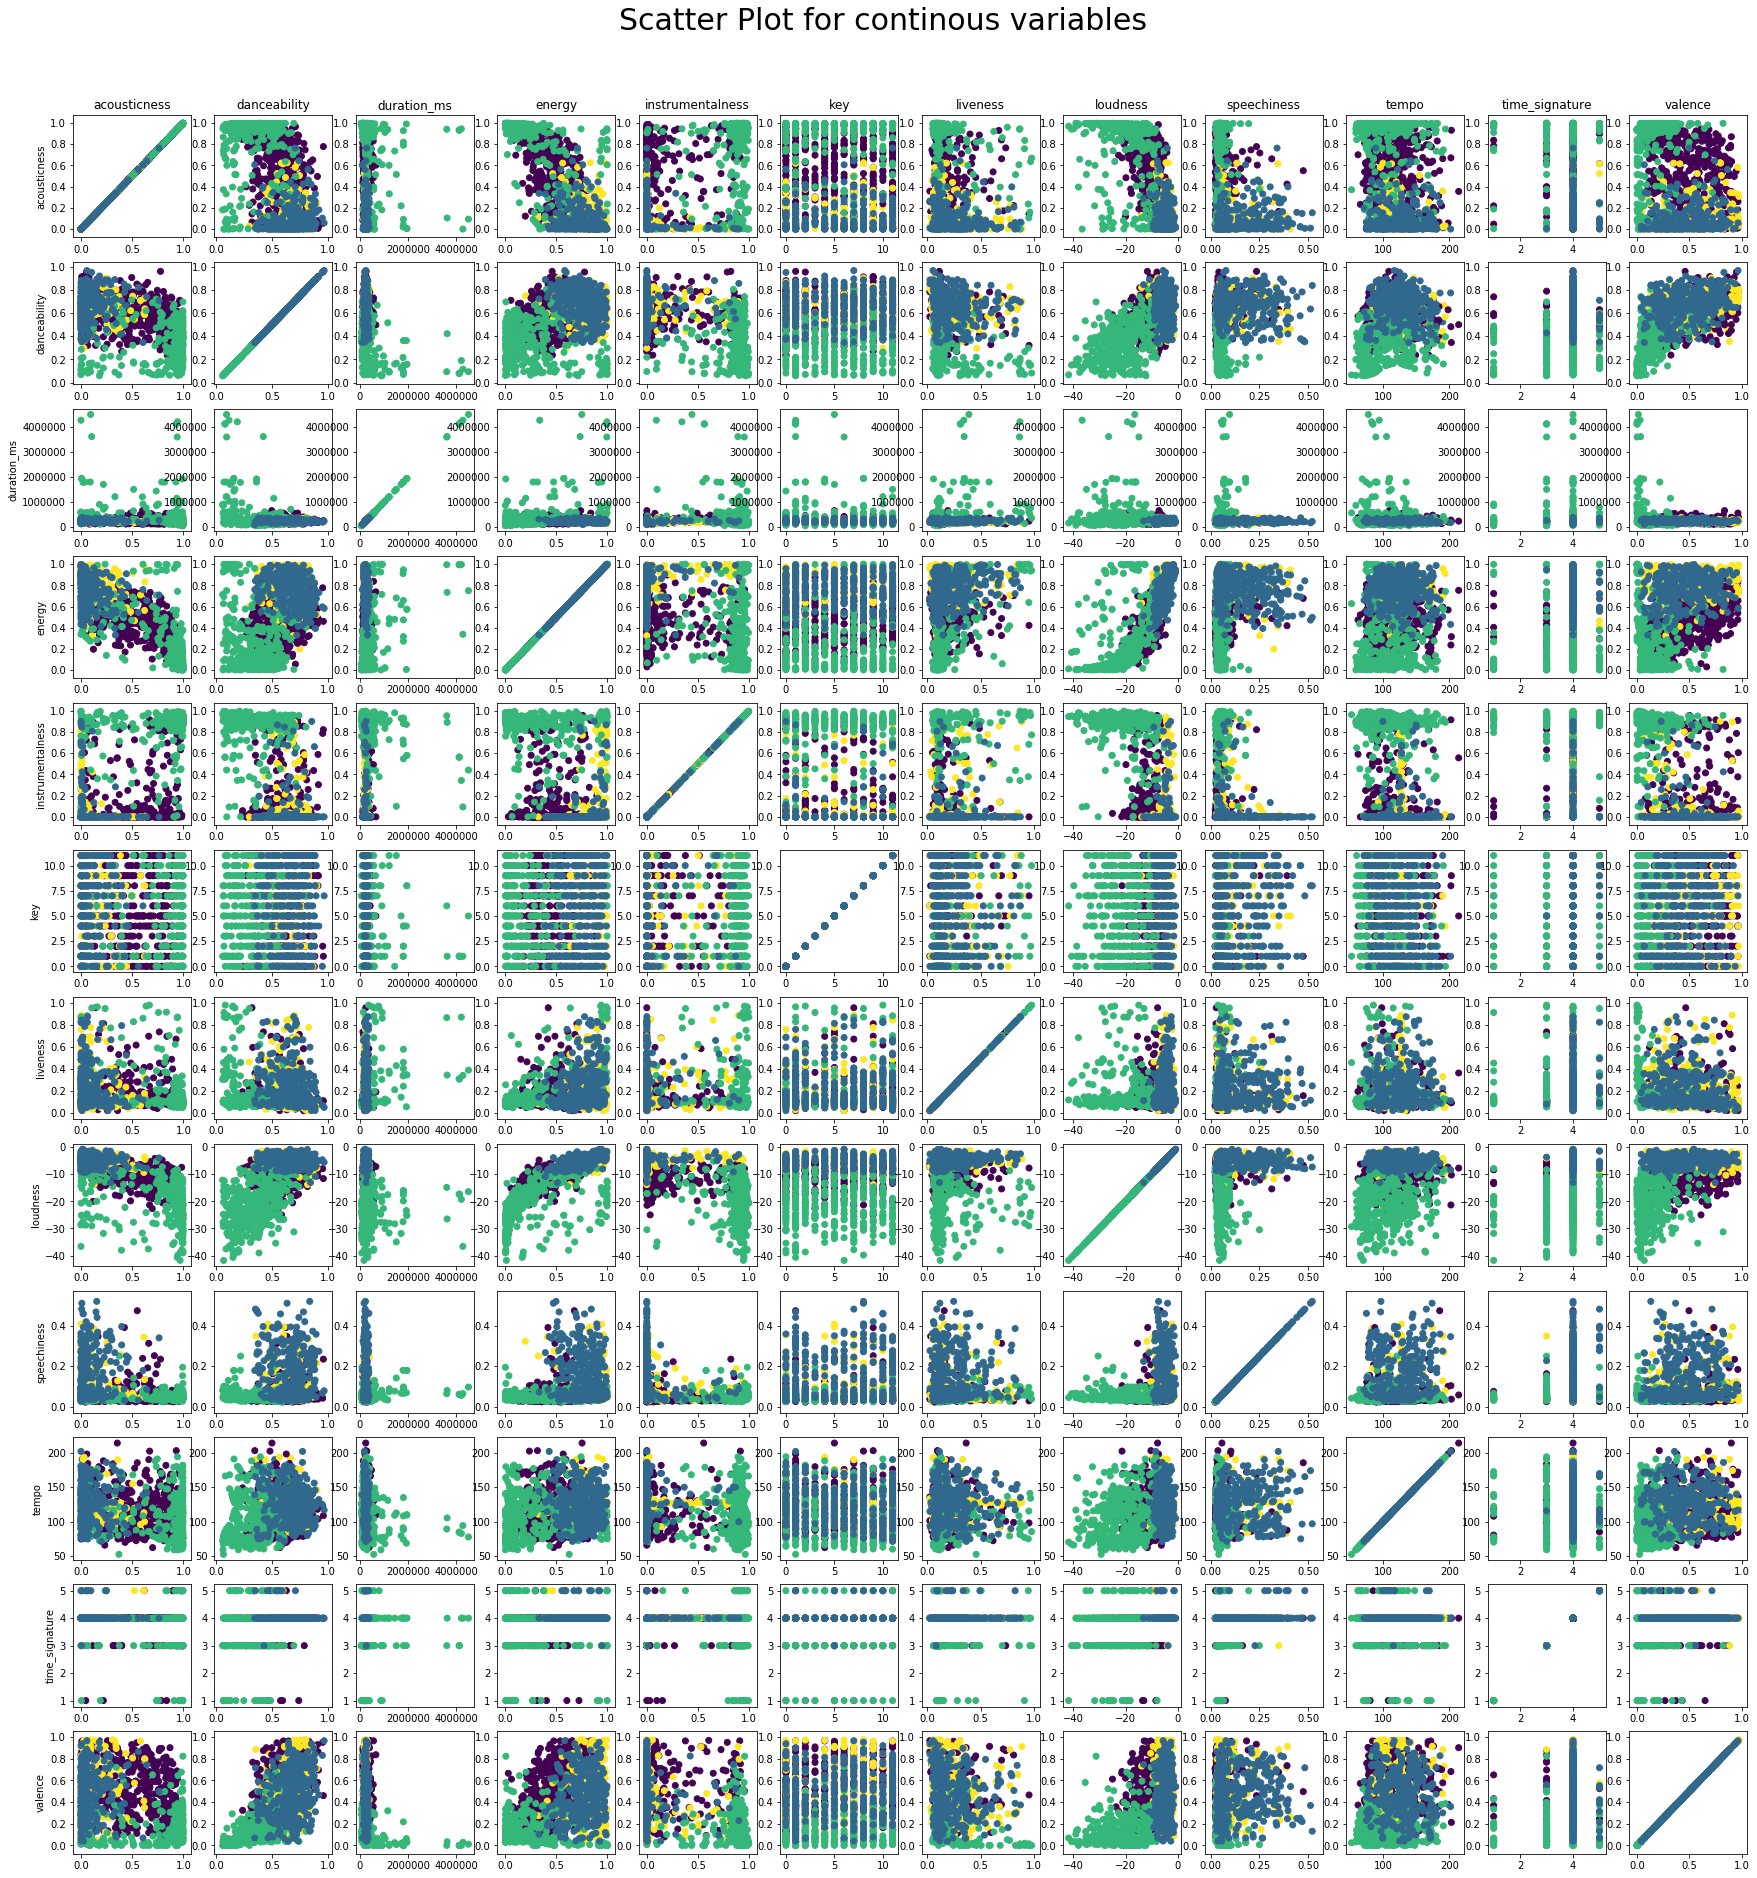

In [16]:
fig,axis=plt.subplots(nrows=12,ncols=12,figsize=(30,30))

for r in range(len(col)):
    for c in range(len(col)):
        axis[c,r].scatter(rebin[[col[r]]],rebin[[col[c]]],c=color)
        axis[0,r].set_title("{}".format(col[r]))
        axis[c,0].set_ylabel("{}".format(col[c]))

fig.suptitle("Scatter Plot for continous variables",fontsize=30) 
fig.subplots_adjust(top=0.93)
plt.show()

#### Among the scatter plots above, the feature valence, acousticness, and instrumentalness seem to have stronger power to separate the instances for different classes. 

#### 1.3. Divide the data using the holdout partition (67% training and 33% testing) and perform classification, since the data is  unbalanced, the stratified sampling is applied to get unbiased results.


In [17]:
ytb=y.replace("dinner",0).replace("sleep",1).replace("workout",2).replace("party",3)

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
x_train,x_test,y_train,y_test=train_test_split(xtb,ytb,test_size=0.33,random_state=100,stratify=ytb)
scaler=StandardScaler()
scaler.fit(x_train)
xtest=scaler.transform(x_test)
xtrain=scaler.transform(x_train)

#### Evaluation Function for the following a),b),c)

In [19]:
from sklearn.metrics import confusion_matrix,accuracy_score
def evaluation(actuall,predict):
    cm=confusion_matrix(actuall,predict)
    FN=cm.sum(axis=1)-np.diag(cm)
    FP=cm.sum(axis=0)-np.diag(cm)
    TP=np.diag(cm)
    TN=cm.sum()-FN-FP-TP
    sensitivity=TP/(TP+FN)
    specificity=TN/(TN+FP)
    accuracy=(TP+TN)/(FN+FP+TP+TN)
    print(cm)
    accu=pd.DataFrame(accuracy).T
    accu.columns=["class1","class2","class3","class4"]
    sen=pd.DataFrame(sensitivity).T
    sen.columns=["class1","class2","class3","class4"]
    spe=pd.DataFrame(specificity).T
    spe.columns=["class1","class2","class3","class4"]
    combine=pd.concat([sen,spe],axis=0)
    combine=pd.concat([combine,accu],axis=0).reset_index(drop=True)
    print("\nOverall Accuracy",accuracy_score(actuall,predict))
    print(pd.concat([pd.DataFrame(["Sensitivity","Specificity","Accuracy"],columns=["matrix"]),combine],axis=1),"\n\n\n")

#### a.	Create a decision tree model and report:
i.	The parameters used for building the decision tree and which parameter configuration that yields the best performance? 
Show the different combinations’ results and how you decided which combination was the best


#### Unlike the parametric model, that is the model is based on the assumptions on the distribution of the data to estimate parameters from the sample data in the model building framework, the CART decision tree algorithm, on the other hand, is a non-parametric model. We don’t have to take the feature distribution into consideration when building the model. But if the features are not categorical variables, we will have to discretize the numerical variables before fitting the model.

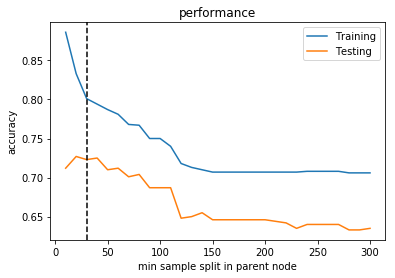

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.S

,Min # of case for parent nodes,Min # case in terminal nodes,Training set accuracy,Testing set accuracy,difference,complexity
0,10,5,0.886,0.712,0.174,78
1,20,10,0.833,0.727,0.106,48
2,30,15,0.801,0.723,0.078,35
3,40,20,0.794,0.725,0.069,30
4,50,25,0.787,0.71,0.077,23
5,60,30,0.781,0.712,0.069,22
6,70,35,0.768,0.701,0.067,19
7,80,40,0.767,0.704,0.063,17
8,90,45,0.75,0.687,0.063,16
9,100,50,0.75,0.687,0.063,15


In [20]:
from sklearn.tree import DecisionTreeClassifier

score_train={}
score_test={}
complexity=[]
min_samples_leaf=[]
for i in range(0,300,10):
    tree=DecisionTreeClassifier(max_depth=100,min_samples_split=i+10,min_samples_leaf=int((i+10)/2),random_state=100)
    tree.fit(xtrain,y_train)
    y_p_train=tree.predict(xtrain)
    y_p_test=tree.predict(xtest)
    score_train[i+10]=np.round(accuracy_score(y_train,y_p_train),3)
    score_test[i+10]=np.round(accuracy_score(y_test,y_p_test),3)
    min_samples_leaf.append(int((i+10)/2))
    complexity.append(len(set(tree.apply(xtrain))))

min_sample_split_train,accuracy_train=list(score_train.keys()),list(score_train.values())
min_sample_split_test,accuracy_test=list(score_test.keys()),list(score_test.values())
difference=list(np.array(accuracy_train)-np.array(accuracy_test))
performance_tb=pd.DataFrame([min_sample_split_train,min_samples_leaf,accuracy_train,accuracy_test,difference,complexity]).T
performance_tb.columns=["Min # of case for parent nodes","Min # case in terminal nodes","Training set accuracy","Testing set accuracy","difference","complexity"]


plt.plot(min_sample_split_train,accuracy_train,label="Training")
plt.plot(min_sample_split_test,accuracy_test,label="Testing")
plt.axvline(x=30, color='k', linestyle='--')
plt.xlabel("min sample split in parent node")
plt.ylabel("accuracy")
plt.title("performance")
plt.legend()
plt.show()

def highlight_greaterthan(s,threshold,column):
    is_max = pd.Series(data=False, index=s.index)
    is_max[column] = s.loc[column] == threshold
    print(type(is_max))
    return ['background-color: yellow' if is_max.any() else '' for v in is_max]

performance_tb.style.apply(highlight_greaterthan,threshold=15,column=['Min # case in terminal nodes'], axis=1)


#### For the experiment, I first set the maximum depth to 100 and try different combinations with the minimum samples in parent node and minimum sample in leaf node.  For the above table, I list out the performance for a different combination of the parameters set, and the optimal set of parameters is when the minimum sample in parent node is 30 and when the minimum sample in the leaf node is 15.  
#### According to the visualization, when the minimum sample in parent node is 30, the performance in training set starts to reach to the knee point and it is also the point that the performance of the testing set is starting to drop. 


#### ii.	For the best parameter configuration, report
1. Misclassification matrix, accuracy, sensitivity, and sensitivity on training data
2. Misclassification matrix, accuracy, sensitivity, and sensitivity on testing data


In [21]:
tree=DecisionTreeClassifier(min_samples_split=30,min_samples_leaf=15,random_state=100)
tree.fit(xtrain,y_train)
p_train=tree.predict(xtrain)
p_test=tree.predict(xtest)
print("Performance on training set\n")
evaluation(y_train,p_train)
print("Performance on testing set\n")
evaluation(y_test,p_test)


#tree.get_params
tree.get_params


Performance on training set

[[271   5  20  17]
 [ 25 215   1   1]
 [ 16   2 179  20]
 [ 26   6  50  97]]

Overall Accuracy 0.8012618296529969
        matrix    class1    class2    class3    class4
0  Sensitivity  0.865815  0.888430  0.824885  0.541899
1  Specificity  0.894984  0.981664  0.903270  0.950777
2     Accuracy  0.885384  0.957939  0.885384  0.873817 



Performance on testing set

[[118   5  20  11]
 [ 11 107   0   2]
 [ 12   1  74  20]
 [ 10   4  34  40]]

Overall Accuracy 0.7228144989339019
        matrix    class1    class2    class3    class4
0  Sensitivity  0.766234  0.891667  0.691589  0.454545
1  Specificity  0.895238  0.971347  0.850829  0.913386
2     Accuracy  0.852878  0.950959  0.814499  0.827292 





<bound method BaseEstimator.get_params of DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=15, min_samples_split=30,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')>

#### The parameter setting for the best configuration in our case is 
Maximum depth=100, Minimum sample in parent node to split=30, Minimum sample in leaf node to split=15, Split criteria= Gini


#### b.	Create a Naïve Bayes classifier 

#### The assumption for Naïve Bayes classifiers is that each feature makes an independent and equal contribution to the outcome. That is, no pair of features are dependent, and each feature is given the same weight (or importance). If the features are numerical, then the assumption is that the features are all normal distributed. In our case, according to the feature distribution plot above, not all the features are normal distributed before normalization.

#### i. report
1.	Misclassification matrix, accuracy, sensitivity, and sensitivity on training data
2.	Misclassification matrix, accuracy, sensitivity, and sensitivity on testing data 

In [22]:
from sklearn.naive_bayes import GaussianNB
GB=GaussianNB(priors=[0.33,0.25,0.23,0.19])
GB.fit(xtrain,y_train)
GB_train_p=GB.predict(xtrain)
GB_test_p=GB.predict(xtest)

evaluation(y_train,GB_train_p)

evaluation(y_test,GB_test_p)

[[230  15  21  47]
 [ 34 207   0   1]
 [  7   0 121  89]
 [  7   0  25 147]]

Overall Accuracy 0.7413249211356467
        matrix    class1    class2    class3    class4
0  Sensitivity  0.734824  0.855372  0.557604  0.821229
1  Specificity  0.924765  0.978843  0.937330  0.822539
2     Accuracy  0.862250  0.947424  0.850683  0.822292 



[[103   8  12  31]
 [ 13 107   0   0]
 [  5   0  50  52]
 [  3   0  16  69]]

Overall Accuracy 0.7014925373134329
        matrix    class1    class2    class3    class4
0  Sensitivity  0.668831  0.891667  0.467290  0.784091
1  Specificity  0.933333  0.977077  0.922652  0.782152
2     Accuracy  0.846482  0.955224  0.818763  0.782516 





C:\Anacon\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### c.	 Create a K-nearest neighbor classifier 

#### the normalization is needed when applying k nearest neighbor algorithm, since the algorithm classifies instances based on the closest distance to the cluster centroid. Without normalization, the classifier might not able to learn accurate pattern from the features in different scales.

#### report

i.	Misclassification matrix, accuracy, sensitivity, specificity results on both training and testing data for values of k equal to 1, 3, and 5.

ii.	What was the similarity measure you used? Was there any need to normalize the data? Explain your answer.


In [23]:
from sklearn.neighbors import KNeighborsClassifier
nb1=KNeighborsClassifier(n_neighbors=1)

nb1.fit(xtrain,y_train)
nb1_train_p=nb1.predict(xtrain)
nb1_test_p=nb1.predict(xtest)
print("When k=1")
print("The performance on training set")
evaluation(y_train,nb1_train_p)
print("The performance on testing set")
evaluation(y_test,nb1_test_p)


nb3=KNeighborsClassifier(n_neighbors=3)
print("When k=3")
nb3.fit(xtrain,y_train)
nb3_train_p=nb3.predict(xtrain)
nb3_test_p=nb3.predict(xtest)
print("The performance on training set")
evaluation(y_train,nb3_train_p)
print("The performance on testing set")
evaluation(y_test,nb3_test_p)


nb5=KNeighborsClassifier(n_neighbors=5)
print("When k=5")
nb5.fit(xtrain,y_train)
nb5_train_p=nb5.predict(xtrain)
nb5_test_p=nb5.predict(xtest)
print("The performance on training set")
evaluation(y_train,nb5_train_p)
print("The performance on testing set")
evaluation(y_test,nb5_test_p)

When k=1
The performance on training set
[[313   0   0   0]
 [  0 242   0   0]
 [  0   0 217   0]
 [  0   0   0 179]]

Overall Accuracy 1.0
        matrix  class1  class2  class3  class4
0  Sensitivity     1.0     1.0     1.0     1.0
1  Specificity     1.0     1.0     1.0     1.0
2     Accuracy     1.0     1.0     1.0     1.0 



The performance on testing set
[[119   6  16  13]
 [  9 109   2   0]
 [ 11   0  57  39]
 [  2   0  32  54]]

Overall Accuracy 0.7228144989339019
        matrix    class1    class2    class3    class4
0  Sensitivity  0.772727  0.908333  0.532710  0.613636
1  Specificity  0.930159  0.982808  0.861878  0.863517
2     Accuracy  0.878465  0.963753  0.786780  0.816631 



When k=3
The performance on training set

C:\Anacon\lib\site-packages\ipykernel\__main__.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Anacon\lib\site-packages\ipykernel\__main__.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Anacon\lib\site-packages\ipykernel\__main__.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[[280   9   9  15]
 [ 13 229   0   0]
 [ 25   2 159  31]
 [ 24   0  24 131]]

Overall Accuracy 0.8401682439537329
        matrix    class1    class2    class3    class4
0  Sensitivity  0.894569  0.946281  0.732719  0.731844
1  Specificity  0.902821  0.984485  0.955041  0.940415
2     Accuracy  0.900105  0.974763  0.904311  0.901157 



The performance on testing set
[[126   7  10  11]
 [ 11 107   1   1]
 [ 17   0  54  36]
 [ 10   0  33  45]]

Overall Accuracy 0.7078891257995735
        matrix    class1    class2    class3    class4
0  Sensitivity  0.818182  0.891667  0.504673  0.511364
1  Specificity  0.879365  0.979943  0.878453  0.874016
2     Accuracy  0.859275  0.957356  0.793177  0.805970 



When k=5
The performance on training set
[[274  11  16  12]
 [ 12 230   0   0]
 [ 19   0 153  45]
 [ 20   0  41 118]]

Overall Accuracy 0.814931650893796
        matrix    class1    class2    class3    class4
0  Sensitivity  0.875399  0.950413  0.705069  0.659218
1  Specificity  0.920063  0.

#### 1.4.	Using two variables that you found to be the most relevant for the classification process.  

#### I access variable importance through tree based importance. For the decision tree, it attempts to split the data into smaller, more homogeneous nodes, and it uses the Gini index or information gain to determine the importance of the variable. 

#### In this problem, the criteria I set to split the tree is the Gini index, and I use the Gini importance to determine the importance of each feature. The Gini importance is defined as the total decrease in node impurity when using the certain feature to split and weighted by the number of samples it splits, the higher the value the more important of the feature. 

#### Down below, we can find that the feature instrumentainess and loudness have the highest value in Gini importance, therefore I plot them on a scatter plot. We can see that there is a clear distinction between the 4 classes in the plot.


In [24]:
#Gini Importance or Mean Decrease in Impurity (MDI)
#The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. 
Gini_importance=pd.DataFrame(tree.feature_importances_).T
Gini_importance.columns=['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence']
print("Gini_importance")
Gini_importance

Gini_importance


,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,0.083757,0.011201,0.010712,0.025912,0.398906,0.003423,0.0,0.259477,0.0,0.094343,0.050547,0.0,0.061723


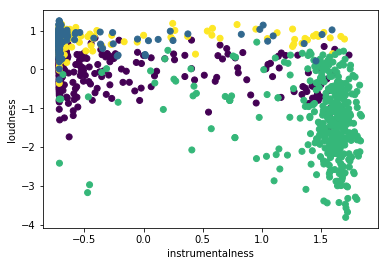

In [25]:
data=pd.DataFrame(scaler.transform(xtb),columns=['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence'])

plt.scatter(data[['instrumentalness']],data[['loudness']],c=color)
plt.xlabel('instrumentalness')
plt.ylabel('loudness')
plt.show()